# Multiclass Classification
Binary classifiers distinguish between two classes, Multiclass classifiers (called Multinomial classifiers) can distinguish between more than two classes.
- LogisticRegression, RandomForestClassifier, GaussianNB handling multiple classes natively. 
- SGDClassifier and SVC are strictly binary classifiers.

There are some strategies to classify multiple classes:
- One-vs-All (aka. One-vs-the-rest (OvR)): build up multiple binary classifier for each image, and choose the highest score of the output of each classifier.
- One-vs-One (OvO) strategy: build the classifier for every pair of the digits. If we have N classes, we need to train N*(N-1)/2 classifiers

Some algorithms (SVM classifier) scale poorly with the size of the training set. So, OvO is also preferred because it is faster to train many classifier on small training sets than to train few classifiers on large training sets. And for most classification algorithms, OvR is preferred.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score, accuracy_score, roc_auc_score, roc_curve
import warnings

warnings.filterwarnings('ignore')

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
X, y = mnist.data, mnist.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=42)

In [6]:
some_digit = X[0]

In [7]:
from sklearn.svm import SVC

# multiclass classifier
svm_clf = SVC(random_state=42)

In [8]:
svm_clf.fit(X_train[:2000], y_train[:2000]) 

SVC(random_state=42)

In [9]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

This code makes 45 predictions (one per pair of classes) and it selects the class that won the most duels. ```decision_function()``` will return 10 scores per instance: one per class.

In [10]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score.round(2)

array([[ 4.81,  1.74,  6.13,  8.3 , -0.3 ,  9.3 ,  2.79,  3.83,  7.26,
         0.73]])

In [11]:
## we can see 9.3 is the highest score for this instance.
some_digit_score.argmax() # return the index (aka. class) of instance

5

In [12]:
## all classes is stored in classifier after training
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [13]:
from sklearn.multiclass import OneVsRestClassifier

## using one-vs-rest multiclass classifier with svm is a core
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [14]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [15]:
list(ovr_clf.estimators_)

[SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42),
 SVC(random_state=42)]

In [16]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [17]:
sgd_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [18]:
sgd_clf.decision_function([some_digit]).round(2)

array([[-12101.09, -31016.96,  -6047.92,   -506.01, -20117.48,   5407.15,
        -26823.42, -10678.03, -11725.05,  -8343.57]])

In [19]:
# accuracy score for sgd_clf
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87747619, 0.88833333, 0.87095238])

We can improve accuracy a bit better by scaling features (StandardScaler())

# Error Analysis
There are some steps todo in the real ml project:
- Explore the data
- Try out multiple models, shortlist the best ones.
- Fine tune their hyperparameters using GridSearchCV, and automate as much as possible.

If we have a good model and finding a way to make it better. First, going to analysis the types of error it made by looking at the Confusion Matrix.

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

<Figure size 1000x1000 with 0 Axes>

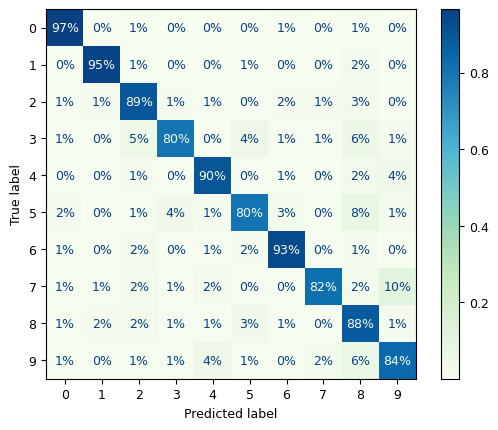

In [21]:
plt.figure(figsize=(10, 10))
plt.rc('font', size=9)   # make the text is smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format='.0%', cmap='GnBu')
plt.show()

Now we can see all classification errors:
- We got 80% correct classified of 5s, 8% misclassify of them as the 8s. Whereas, 3% of 8s were misclassified as 5s.
- There are many digit have been misclassified as 8s, and the class 5s too.

Setup the ```sample_weight=``` parameter to make more information of error.

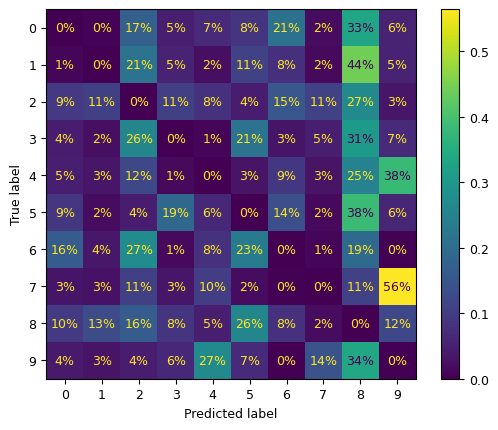

In [22]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format='.0%')
plt.show()

Now, we can see much nore clearly what kind of errors classifier makes. Looking at the class 8s that many image misclassified as 8s. For example, there are 26% of the classifier makes error prediction of class 5s as class 8s. The same as class 7s with 56% predicted class 9s as 7s.

To improve the classifier, for example, to reduce the false 8s. We can gather more images look like 8s but not the 8s, so that the classifier can learn to distinguish them from real 8s. or we can develop a new feature that would help the classifier. or preprocess the images (OpenCV, Pillow, or sklearn-image) to make some patterns

#### Notices
A simple SGDClassifier is a linear model, it assigns a weight per class to each pixel, and when it sees a new image with sum up the weighted pixel intensities to get a score for each class. So, 3s and 5s is only differ by a few pixels, this model is easy to confuse them.

Simple technique to improve model is the shifted and rotated variants of the training images. The model will learn more variations. This is called __data augmentation__

## Multilabel Classification
We had done to classify each instance assigned to just one class. Now, we go to classify each instance to multiple classes as output.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel[:3]

array([[ True, False],
       [ True,  True],
       [False, False]])

In [24]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [25]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [26]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [27]:
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9767133796163985

In [28]:
## we got little bit performance improvement when set average='weighted' because the classes are really well balanced
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9781767664691019

#### Model classifier does not naively support multilabel classification
ClassifierChain() uses true label for training, feeding each model the appropriate labels depending on their position in the chain. If seting __cv hyperparameter__ in the chain, it will use cross-validation to get 'clean' (out of sample) predictions from each trained model, for every instance in the training set, and these predictions will then be used to train all the models later in the chain.

In [29]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)

In [30]:
chain_clf.fit(X_train[:2000], y_multilabel[:2000])  # use small training set to speed up

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [31]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Multioutput Classification
First, remove noise from images, the output is clean digit image, represented as an array of pixel intensities (like mnist's images). The classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 too 255)

In [37]:
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test
## classify the noise images with cleaned images

In [33]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

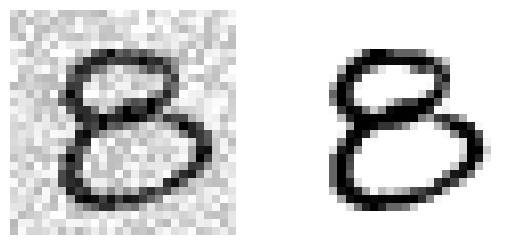

In [34]:
plt.subplot(121); plot_digit(X_train_mod[0])
plt.subplot(122); plot_digit(y_train_mod[0])
plt.show()

In [38]:
# build model
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digits = knn_clf.predict([X_test_mod[0]])

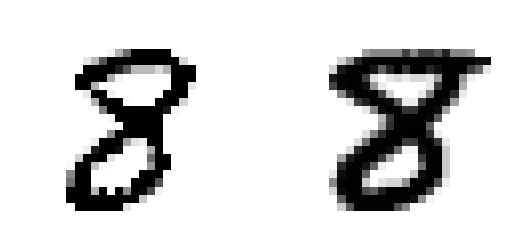

In [43]:
plt.subplot(121); plot_digit(clean_digits)
plt.subplot(122); plot_digit(y_test_mod[0])
plt.show()

In [45]:
## accuracy for multioutput is not supported
# baseline_acc = knn_clf.score(X_test_mod, y_test_mod)
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)


KNeighborsClassifier()

In [48]:
knn_clf.predict(X_test)

array(['8', '4', '8', ..., '5', '2', '6'], dtype=object)

In [49]:
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy

0.9701428571428572

In [50]:
# improve the model with GridSearchCV()
from sklearn.model_selection import GridSearchCV

params = [
    {'weights': ['uniform', 'distance'], 'n_neighbors': [3, 4, 5, 8]}
]
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, params, cv=5)
grid_search.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 8],
                          'weights': ['uniform', 'distance']}])

In [51]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [52]:
grid_search.best_score_

0.9484999999999999

In [53]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [54]:
tuned_accuracy = best_model.score(X_test, y_test)
tuned_accuracy

0.9751428571428571